# Analysis part

In [2]:
library(ggplot2)
library(quantreg)


df = read.csv('merged_datasets_final/merged_Charizard_Reverse_Foil_2016_Evolutions.csv')

#convert prices to returns
grades <- grep("grade[0-9]+price", names(df), value = TRUE)
grade_returns <- sapply(grades, function(x) paste0(x, "_return"))

for(grade in grades) {
  df[paste(grade, "return", sep = "_")] <- c(NA, diff(log(df[[grade]])))
}

#convert adjclosestock to returns
df$adjclosestock_return <- c(NA, diff(log(df$adjclosestock)))

#remove rows with NA in the newly created return columns
df <- na.omit(df)

head(df)

,date,grade8price,grade9price,grade10price,adjclosestock,volume,adjclosebond,stockreturns,bondadjusted,excessreturns,grade8price_return,grade9price_return,grade10price_return,adjclosestock_return
2,2017-01-01,10.50,16.07000,264.2200,2278.87,70576420000,3.051,0.0178843582,0.03051,0.02180204,0.00000000,-0.3064837,0.00000000,0.0177263146
3,2017-02-01,10.50,28.75000,304.1667,2363.64,69260940000,2.968,0.0371981601,0.02968,0.06440241,0.00000000,0.5816836,0.14079371,0.0365230007
4,2017-03-01,10.50,16.12500,210.0000,2362.72,81664010000,3.018,-0.0003891971,0.03018,-0.01723554,0.00000000,-0.5782669,-0.37046827,-0.0003892729
5,2017-04-01,10.50,13.51000,155.5900,2384.20,65369860000,2.952,0.0090912087,0.02952,0.03095999,0.00000000,-0.1769407,-0.29988319,0.0090501325
6,2017-05-01,9.99,16.82333,113.6560,2411.80,79719460000,2.857,0.0115762512,0.02857,0.04375775,-0.04979066,0.2193367,-0.31404800,0.0115097591
7,2017-06-01,13.99,21.49167,107.2500,2423.41,81078810000,2.840,0.0048137752,0.02840,0.01076414,0.33675820,0.2448985,-0.05801378,0.0048022260


## Visualisation

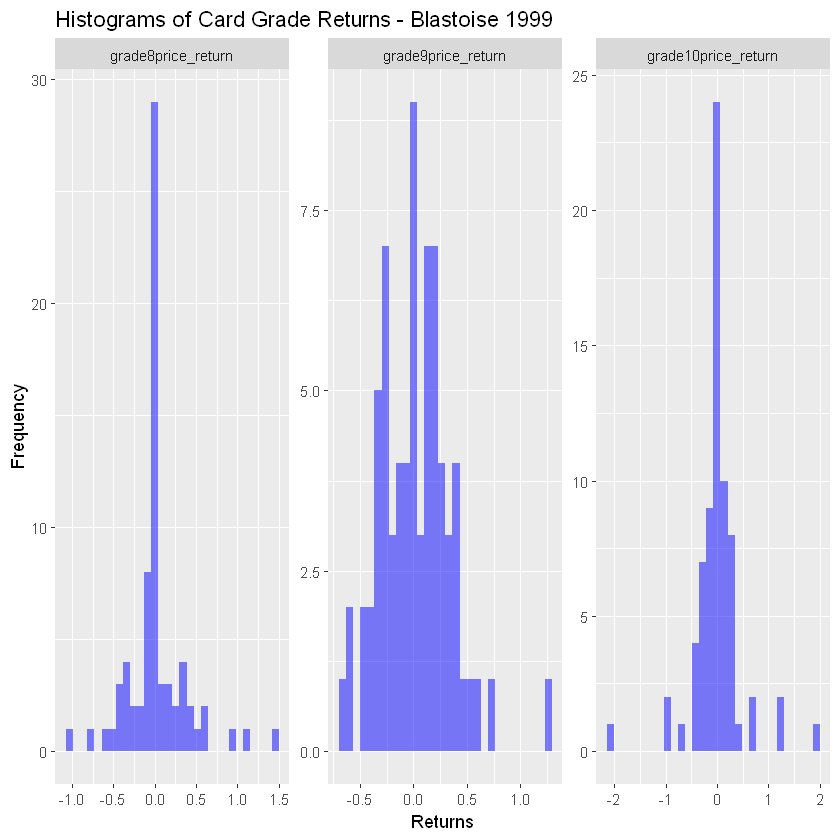

In [3]:

#create a long format data frame suitable for faceting with returns
long_df <- reshape2::melt(df, id.vars = "date", measure.vars = grade_returns)

#histograms for card grade returns
p1 <- ggplot(long_df, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", alpha = 0.5) +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Returns", y = "Frequency", title = "Histograms of Card Grade Returns - Blastoise 1999")

print(p1)

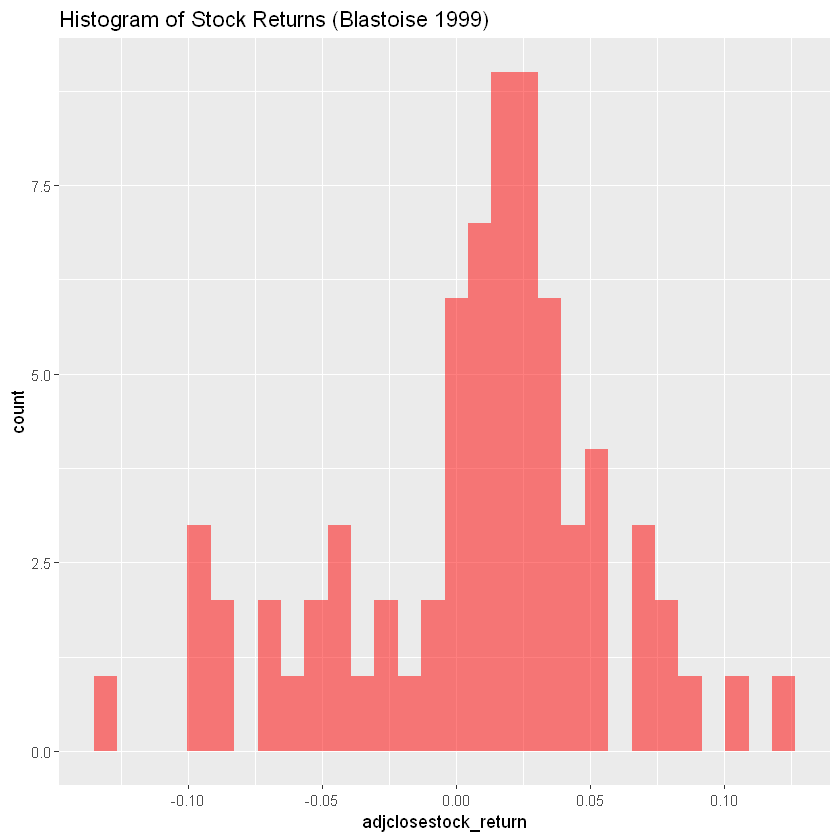

In [4]:
#histogram of stock returns
p2 <- ggplot(df, aes(x = adjclosestock_return)) +
  geom_histogram(bins = 30, fill = "red", alpha = 0.5) +
  labs(title = "Histogram of Stock Returns (Blastoise 1999)")

print(p2)

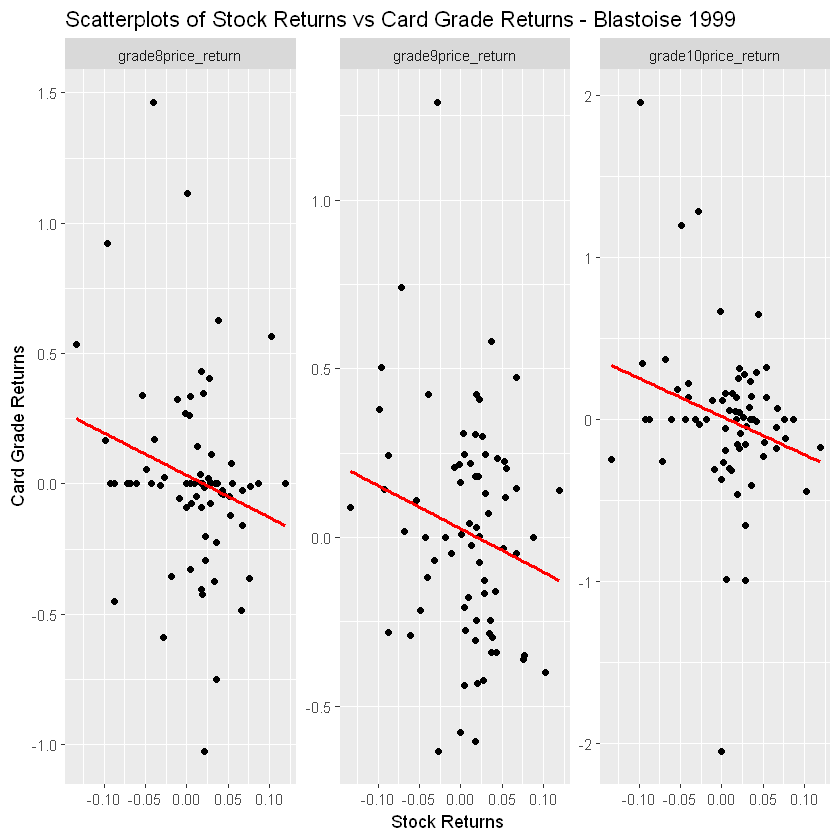

In [5]:
#a long format data frame suitable for scatterplots with returns
long_df <- reshape2::melt(df, id.vars = c("date", "adjclosestock_return"), measure.vars = grade_returns)

#scatterplots between stock returns and card grades returns
p3 <- ggplot(long_df, aes(x = adjclosestock_return, y = value)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Stock Returns", y = "Card Grade Returns", title = "Scatterplots of Stock Returns vs Card Grade Returns - Blastoise 1999")

print(p3)

## Models

### OLS

In [6]:
#OLS
ols_models <- list()
for(grade_return in grade_returns) {
  ols_models[[grade_return]] <- lm(get(grade_return) ~ adjclosestock_return, data = df)
}

#print summary of each OLS model
for(grade_return in grade_returns) {
  print(paste("Summary of model for:", grade_return))
  print(summary(ols_models[[grade_return]]))
}


[1] "Summary of model for: grade8price_return"

Call:
lm(formula = get(grade_return) ~ adjclosestock_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.02493 -0.13520 -0.01579  0.11239  1.36527 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)           0.03380    0.04345   0.778   0.4392  
adjclosestock_return -1.61991    0.87019  -1.862   0.0669 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3645 on 70 degrees of freedom
Multiple R-squared:  0.04717,	Adjusted R-squared:  0.03356 
F-statistic: 3.465 on 1 and 70 DF,  p-value: 0.06686

[1] "Summary of model for: grade9price_return"

Call:
lm(formula = get(grade_return) ~ adjclosestock_return, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.69531 -0.25197  0.00249  0.21254  1.22830 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.02577    0.03903   0.

### Quantile regression

In [7]:
#Quantile regression
library(quantreg)

quantile_models <- list()
for(grade_return in grade_returns) {
  quantile_models[[grade_return]] <- rq(get(grade_return) ~ adjclosestock_return, data = df, tau = 0.1)  #change tau for different quantiles
}

#print summary of quantile regression models
for(grade_return in grade_returns) {
  print(paste("Summary of quantile regression model for:", grade_return))
  print(summary(quantile_models[[grade_return]]))
}


[1] "Summary of quantile regression model for: grade8price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.38453     -0.49571 -0.23525
adjclosestock_return  0.26775     -3.76764  3.98650
[1] "Summary of quantile regression model for: grade9price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.33695     -0.52578 -0.29061
adjclosestock_return -0.61665     -2.81454  1.40494
[1] "Summary of quantile regression model for: grade10price_return"

Call: rq(formula = get(grade_return) ~ adjclosestock_return, tau = 0.1, 
    data = df)

tau: [1] 0.1

Coefficients:
                     coefficients lower bd upper bd
(Intercept)          -0.37084     -0.79328 -0.30765
adjclosestock_return -0.9421

In [8]:
#Quantile regression
library(quantreg)

quantile_models <- list()
for(grade_return in grade_returns) {
  quantile_models[[grade_return]] <- rq(get(grade_return) ~ adjclosestock_return, data = df, tau = seq(from=0.05, to=0.95, by=0.05))  #change tau for different quantiles
}

#print summary of quantile regression models
for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
}

#uncomment the last two commented rows (in the previous loop) if you want to see the results for quantiles from 0.05 to 0.95, by 0.05 step

#### Results for different quantiles of the grade prices x OLS estimates (red line) 

Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"

Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"Warning message in rq.fit.br(x, y, tau = tau, ci = TRUE, ...):
"Solution may be nonunique"

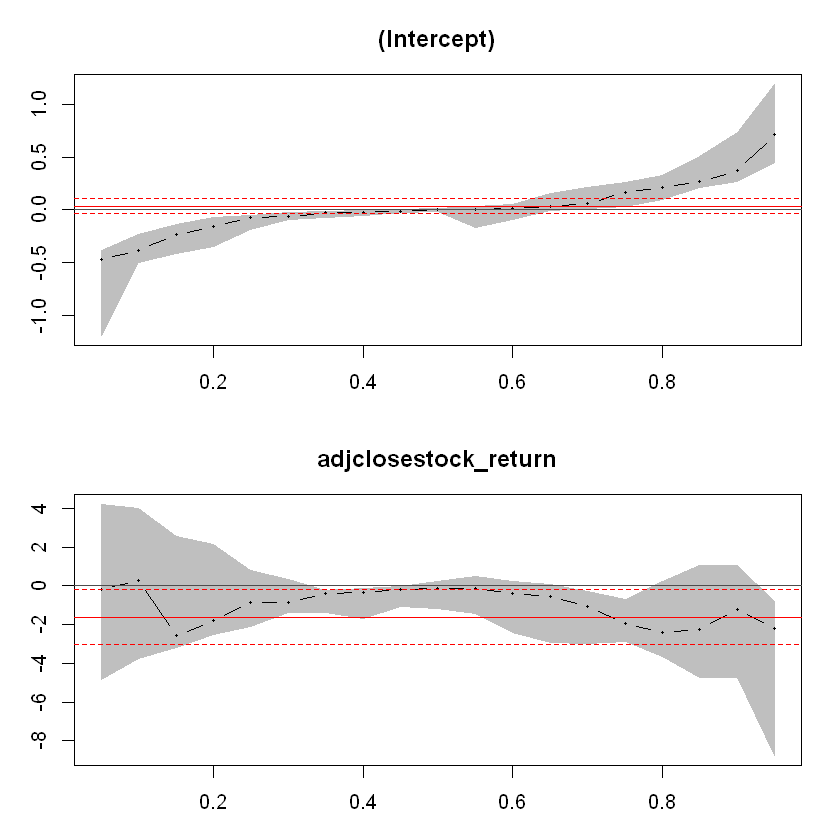

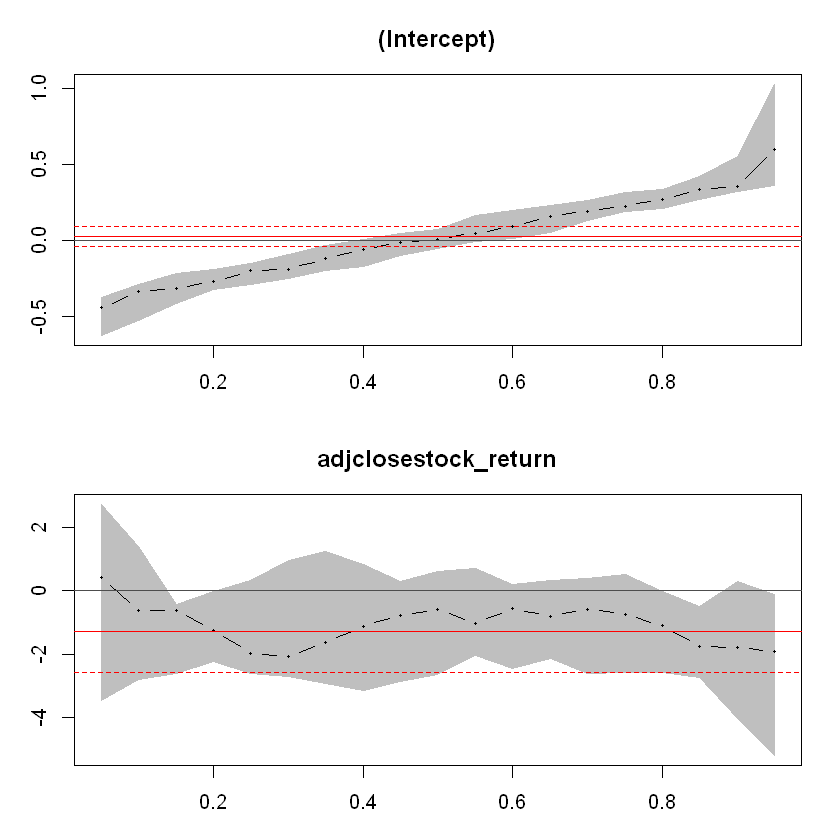

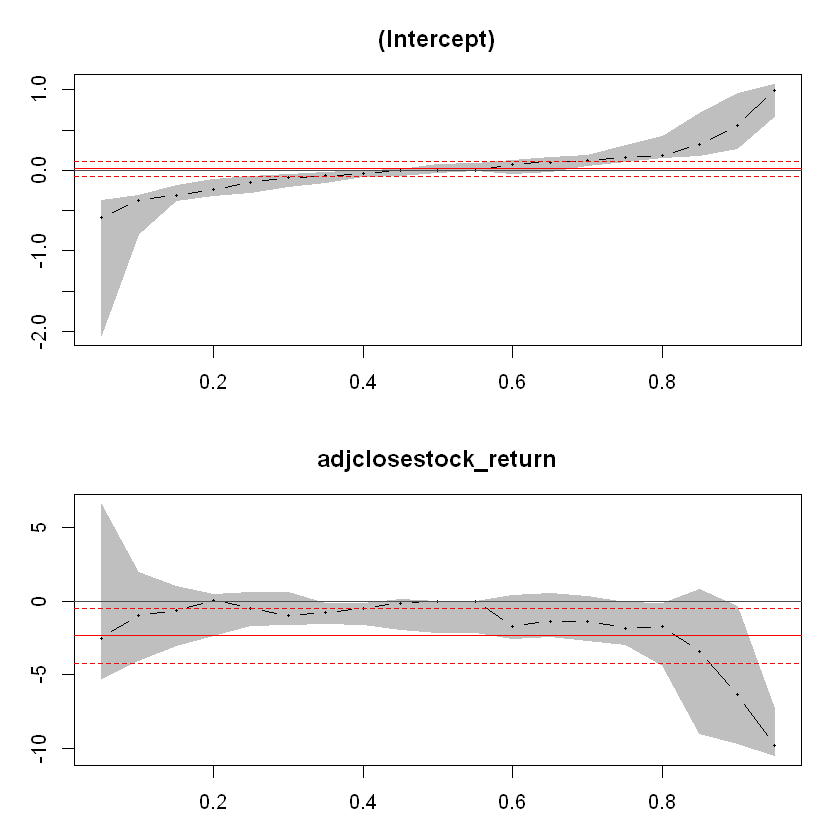

In [9]:

for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
  plot(summary(quantile_models[[grade_return]]))
}